In [ ]:
import os
import zipfile

import shutil

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B2, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

import time

In [ ]:
import gdown
url = 'https://drive.google.com/uc?id=1jGKC9pNjrWqJJTMJRFDnKD5W-GAl1xhV&export=download'
output = 'dataset.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1jGKC9pNjrWqJJTMJRFDnKD5W-GAl1xhV&export=download
From (redirected): https://drive.google.com/uc?id=1jGKC9pNjrWqJJTMJRFDnKD5W-GAl1xhV&export=download&confirm=t&uuid=22327ee0-63b5-4632-8364-16b15e35d524
To: /content/dataset.zip
100%|██████████| 173M/173M [00:02<00:00, 75.8MB/s]


'dataset.zip'

In [ ]:
# Ekstrak dataset
local_zip = '/content/dataset.zip'
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall('/content/file')

data_path = '/content/file'
# Periksa direktori yang diekstrak
print(os.listdir(data_path))

['dataset']


In [ ]:
train_dir = '/content/file/dataset/train'
val_dir = '/content/file/dataset/val'
test_dir = '/content/file/dataset/test'

In [ ]:
# Tentukan parameter
batch_size = 32
img_height = 260
img_width = 260
epochs = 20

In [ ]:
# Buat ImageDataGenerator
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [ ]:
# ImageDataGenerator untuk data validasi (tanpa augmentasi)
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [ ]:
# ImageDataGenerator untuk data testing
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [ ]:
# Buat generator untuk data training
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

Found 6908 images belonging to 2 classes.


In [ ]:
# Generator untuk data validasi
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

Found 1973 images belonging to 2 classes.


In [ ]:
# Generator untuk data testing
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 988 images belonging to 2 classes.


In [ ]:
# Load model EfficientNetV2 tanpa lapisan atas (include_top=False)
base_model = EfficientNetV2B2(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

# Bekukan lapisan base_model
base_model.trainable = False

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Tambahkan lapisan atas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)

# Buat model lengkap
model = Model(inputs=base_model.input, outputs=outputs)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 260, 260, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 260, 260, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 260, 260, 3)    │              0 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 130, 130, 32)   │            864 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 130, 130, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 130, 130, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 130, 130, 16)   │          4,608 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 130, 130, 16)   │             64 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 130, 130, 16)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 130, 130, 16)   │          2,304 │ block1a_project_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 130, 130, 16)   │             64 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 130, 130, 16)   │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 130, 130, 16)   │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)         │ (None, 130, 130, 16)   │              0 │ block1b_drop[0][0],    │
│                           │                        │                │ block1a_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_conv  

 Total params: 8,770,783 (33.46 MB)

 Trainable params: 1,409 (5.50 KB)

 Non-trainable params: 8,769,374 (33.45 MB)

In [ ]:
# Kompilasi model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Tambahkan EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=6,
    restore_best_weights=True
)

In [ ]:
# Hitung waktu komputasi
start_time_training = time.time()

# Latih model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[early_stop]
)

end_time_training = time.time()
training_time = end_time_training - start_time_training
print(f"Waktu komputasi training: {training_time:.2f} detik")

Epoch 1/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 120s 540ms/step - accuracy: 0.9142 - loss: 0.2208 - val_accuracy: 0.9314 - val_loss: 0.1944
Epoch 2/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - accuracy: 0.8750 - loss: 0.2770 - val_accuracy: 0.9524 - val_loss: 0.1795
Epoch 3/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 141s 541ms/step - accuracy: 0.9212 - loss: 0.2120 - val_accuracy: 0.9406 - val_loss: 0.1672
Epoch 4/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step - accuracy: 0.9375 - loss: 0.2522 - val_accuracy: 0.9048 - val_loss: 0.2169
Epoch 5/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 119s 538ms/step - accuracy: 0.9294 - loss: 0.1995 - val_accuracy: 0.9390 - val_loss: 0.1703
Epoch 6/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step - accuracy: 0.9688 - loss: 0.1580 - val_accuracy: 0.9524 - val_loss: 0.1429
Epoch 7/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 142s 535ms/step - accuracy: 0.9230 - loss: 0.1947 - val_accuracy: 0.9411 - val_loss: 0.1653
Epoch 8/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - accuracy: 0.9375 - loss: 0

In [ ]:
# Hitung waktu testing
start_time_testing = time.time()

# Evaluasi model pada data testing
test_loss, test_acc = model.evaluate(
    test_generator,
    steps=test_generator.samples // batch_size
)
print('Akurasi pada data testing:', test_acc)

end_time_testing = time.time()
testing_time = end_time_testing - start_time_testing
print(f"Waktu komputasi testing: {testing_time:.2f} detik")

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9789 - loss: 0.1002
Akurasi pada data testing: 0.934374988079071
Waktu komputasi testing: 2.78 detik


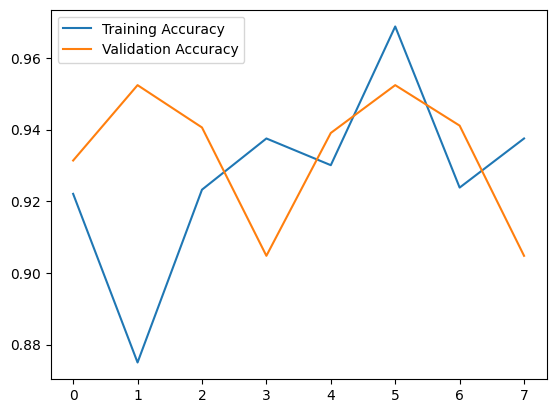

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

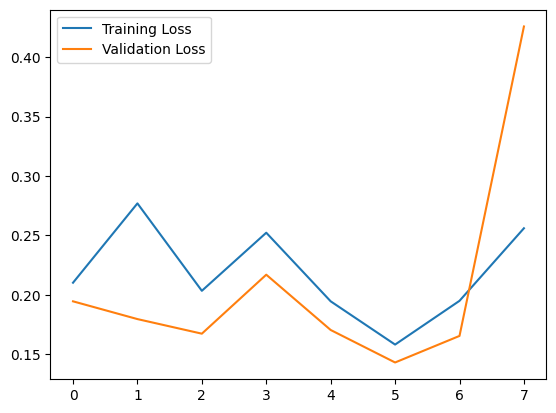

In [ ]:
# Plot loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 18s 336ms/step


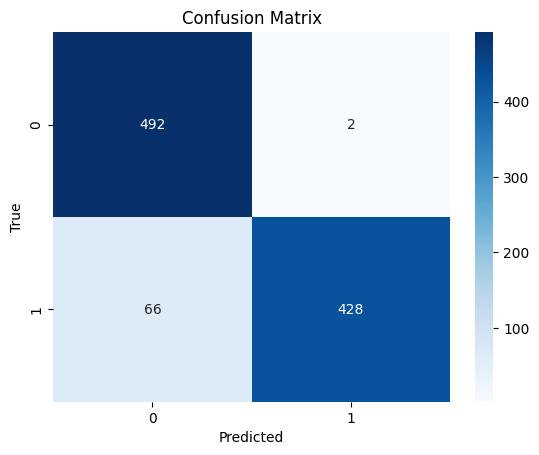

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Buat prediksi pada data testing
y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)

# Dapatkan label sebenarnya dari generator
y_true = test_generator.classes

# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Tampilkan confusion matrix menggunakan seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Hitung metrik
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Tampilkan hasil
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.9312
Precision: 0.9953
Recall: 0.8664
F1-score: 0.9264


In [ ]:
from sklearn.metrics import average_precision_score

# Asumsikan y_true dan y_pred adalah array numpy yang berisi label sebenarnya dan prediksi probabilitas
# Untuk setiap kelas

y_pred_proba = model.predict(test_generator)  # Dapatkan prediksi probabilitas

average_precision = average_precision_score(y_true, y_pred_proba)

print(f"Average precision score: {average_precision:.4f}")


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step
Average precision score: 0.9869


In [ ]:
# Simpan model
model.save('efficientnetv2_drowsiness_model.h5')

In [ ]:
from sklearn.metrics import classification_report

# Hitung laporan klasifikasi
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())

# Tampilkan laporan klasifikasi
print(report)


              precision    recall  f1-score   support

      closed       0.88      1.00      0.94       494
        open       1.00      0.87      0.93       494

    accuracy                           0.93       988
   macro avg       0.94      0.93      0.93       988
weighted avg       0.94      0.93      0.93       988



In [ ]:
from google.colab import files

files.download('efficientnetv2_drowsiness_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


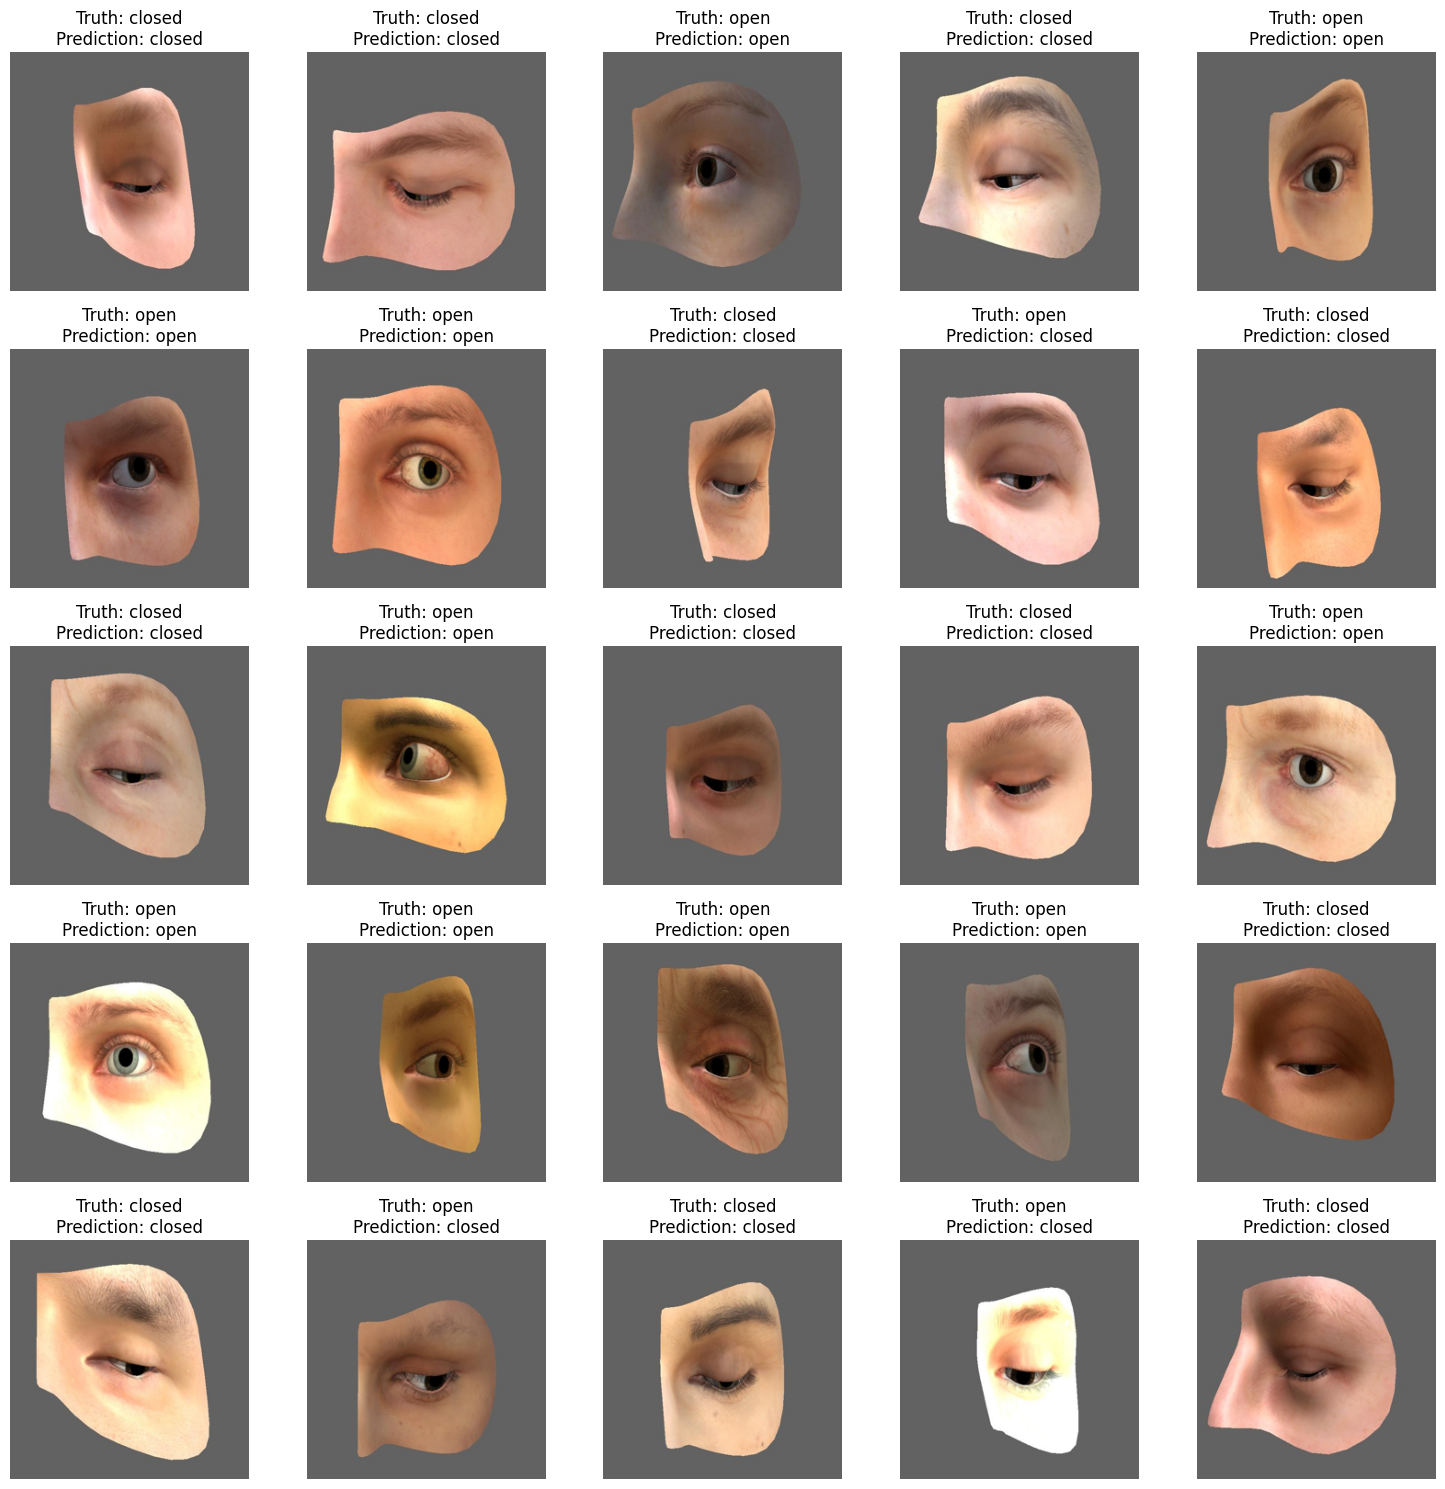

In [ ]:
import matplotlib.pyplot as plt
import os
import random
from PIL import Image

# Definisikan direktori test
test_dir = '/content/file/dataset/test'

# Daftar kelas
class_names = sorted(os.listdir(test_dir))

# Jumlah gambar yang akan ditampilkan
num_images = 25

# Ukuran frame
rows = 5
cols = 5

# Buat figure dan axes
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

# Loop untuk menampilkan gambar
for i in range(num_images):
    # Pilih kelas secara acak
    class_name = random.choice(class_names)

    # Pilih gambar secara acak dari kelas tersebut
    image_path = os.path.join(test_dir, class_name, random.choice(os.listdir(os.path.join(test_dir, class_name))))

    # Buka gambar menggunakan PIL
    img = Image.open(image_path)

    # Prediksi kelas gambar
    img = img.resize((img_width, img_height))  # Ubah ukuran gambar
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Tambahkan dimensi batch
    img_array = preprocess_input(img_array)  # Praproses gambar

    prediction = model.predict(img_array)
    predicted_class = "open" if prediction > 0.5 else "closed"

    # Tampilkan gambar pada axes
    row = i // cols
    col = i % cols
    axes[row, col].imshow(img)
    axes[row, col].set_title(f"Truth: {class_name}\nPrediction: {predicted_class}")
    axes[row, col].axis('off')

# Tampilkan plot
plt.tight_layout()
plt.show()